In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Load the numpy array X from the compressed .npz file
X_train = np.load('/content/drive/MyDrive/X_train.npz')
X_test  = np.load('/content/drive/MyDrive/X_test.npz')

Y_train = np.load('/content/drive/MyDrive/Y_train.npz')
Y_test  = np.load('/content/drive/MyDrive/Y_test.npz')


X_train =X_train['X']
X_test  =X_test ['X']

Y_train =Y_train['X']
Y_test  =Y_test ['X']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from tensorflow.keras import layers, models, Input, Model
import numpy as np

def create_flexible_encoder_decoder_fixed_filter(input_shape, layer_filters, filter_size):
    """
    Create a flexible CNN Encoder-Decoder with customizable layers and a fixed filter size.

    Parameters:
    - input_shape: tuple, shape of the input image (height, width, channels).
    - layer_filters: list of ints, number of filters for each encoder/decoder layer.
                     The decoder uses the same filters in reverse order.
    - filter_size: tuple, fixed filter size for all layers (e.g., (3, 3)).

    Returns:
    - autoencoder: The full encoder-decoder model.
    - encoder: The encoder model for feature extraction.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Encoder
    x = inputs
    for filters in layer_filters:
        x = layers.Conv2D(filters, filter_size, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = x  # Encoded representation

    # Decoder
    for filters in reversed(layer_filters):
        x = layers.Conv2D(filters, filter_size, activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(input_shape[2], filter_size, activation='sigmoid', padding='same')(x)

    # Define the encoder-decoder model
    autoencoder = Model(inputs, decoded)

    # Define the encoder model for feature extraction
    encoder = Model(inputs, encoded)
    decoder = Model(encoded, decoded)
    return autoencoder, encoder , decoder


In [4]:
#with crossvalidation tawel we mo2rf 5 sa3at leeeeeeeeeh
def cross_validate_autoencoder(X, hidden_layer_configs,filters , folds = 5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    input_shape = X.shape[1:]



    histories = {}   #save the history of each configuration training
    best_loss_ever = float('inf')  # Initialize the best loss
    best_AutoEncoder = None  # Placeholder for the best model
    best_Encoder = None
    best_Decoder = None

    for i , hidden_layers  in enumerate(hidden_layer_configs):
        best_fold_history = None
        best_fold_loss=float('inf')
        print(f"Training with {hidden_layers} hidden layers")
        for k,(train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"Fold {k+1}/{folds}")
            X_train, X_val = X[train_idx], X[val_idx]
            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')

            # Build and compile the autoencoder
            autoencoder, encoder, decoder = create_flexible_encoder_decoder_fixed_filter(input_shape, hidden_layers ,filters[i])
            autoencoder.compile(optimizer="nadam", loss="mse",metrics =["accuracy"])

            # Train the autoencoder
            history = autoencoder.fit(X_train, X_train,
                                       epochs=6,
                                       batch_size=32,
                                       validation_data=(X_val, X_val),
                                       callbacks=[early_stop],
                                       verbose=1)

            # Evaluate on validation data
            loss = min(history.history['val_loss'])


            #target is to save the history for best crossvalidation
            if loss < best_fold_loss:
                best_fold_loss = loss
                best_fold_history = history  # Save the best fold's training history


            #save the model with best configuration
            if loss < best_loss_ever:
                best_loss_ever= loss
                best_AutoEncoder  = autoencoder     # Save the current best model
                best_Encoder  = encoder
                best_Decoder  = decoder

        histories[str(hidden_layers)] = best_fold_history  # Store the history for the best fold

    return  histories ,best_AutoEncoder,best_Encoder,best_Decoder


In [5]:
from warnings import filters

hidden_layer_configs = [
    [64],               # Single hidden layer with 64 neurons
    [128],
    [64 ,128],
    [128, 256],
    [64 , 128 ,256],
    
    [64],               # Single hidden layer with 64 neurons
    [128],
    [64 ,128],
    [128, 256],
    [64 , 128 ,256],
    
]
filters = [
    (3, 3),
    (3, 3),
    (3, 3),
    (3, 3),
    

    (5, 5),
    (5, 5),
    (5, 5),
    (5, 5),
    
]
# Perform cross-validation
histories,autoencoder,encoder,decoder= cross_validate_autoencoder(X_train, hidden_layer_configs ,filters,folds = 5 )

Training with [64] hidden layers
Fold 1/5
Epoch 1/6
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9550 - loss: 0.0039 - val_accuracy: 0.9993 - val_loss: 4.0941e-04
Epoch 2/6
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9993 - loss: 3.8866e-04 - val_accuracy: 0.9994 - val_loss: 3.2852e-04
Epoch 3/6
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9991 - loss: 2.4327e-04 - val_accuracy: 0.9994 - val_loss: 2.9589e-04
Epoch 4/6
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9993 - loss: 1.8922e-04 - val_accuracy: 0.9995 - val_loss: 1.0347e-04
Epoch 5/6
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9994 - loss: 1.5465e-04 - val_accuracy: 0.9996 - val_loss: 1.2702e-04
Epoch 6/6
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9994 - loss: 1.2625e-04 - val_accuracy: 0.9996 - val_loss: 9.3125e-05
Fold 2/5
Epoch 1/6
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9816 - loss: 0.0047 - val_accuracy: 0.9993 - val_loss: 4.4457e-04
Epoch

In [6]:
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 3)           │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,356 (474.05 KB)

 Trainable params: 40,451 (158.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,905 (316.04 KB)

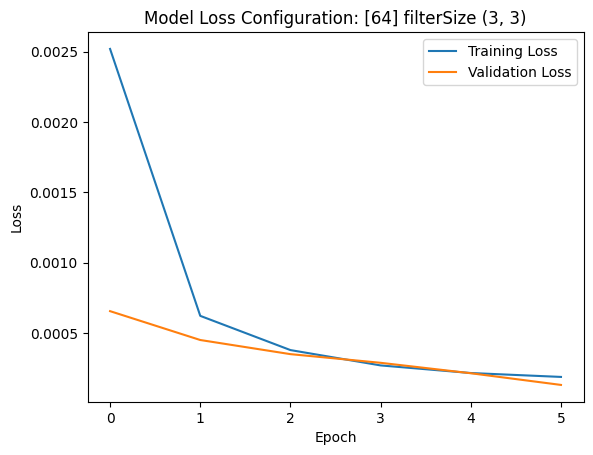

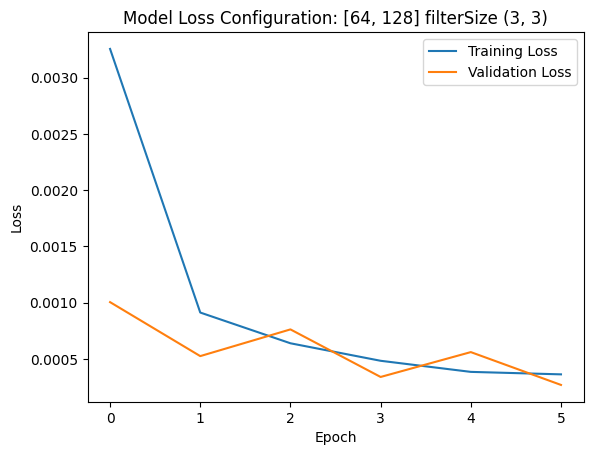

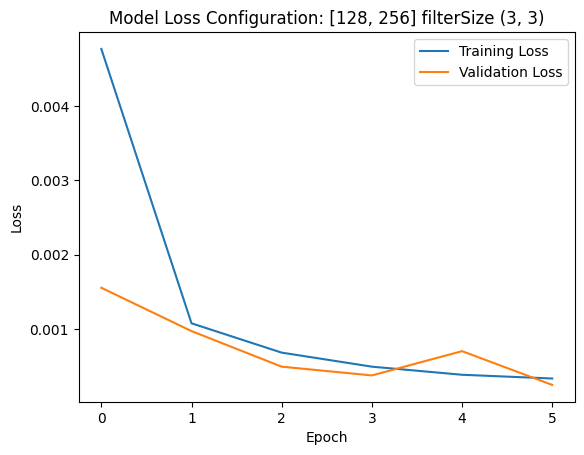

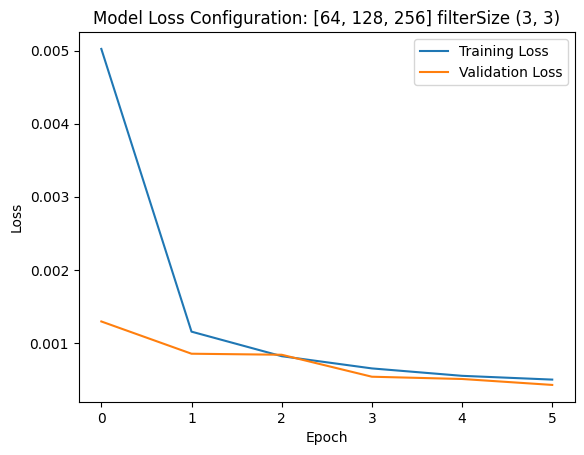

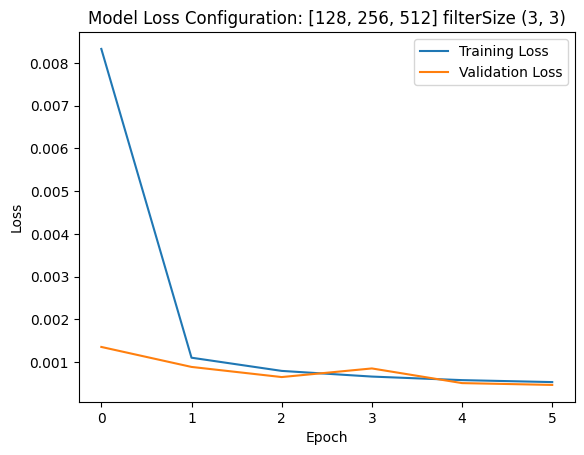

IndexError: list index out of range

In [7]:
for i,_ in enumerate(hidden_layer_configs):
    key = list(histories.keys())[i]  # Get the second key in the dictionary
    history = histories[key]


    loss = history.history['loss']
    val_accuracy = history.history['val_loss']
    plt.plot(loss, label='Training Loss')
    plt.plot(val_accuracy, label='Validation Loss')
    plt.title(f"Model Loss Configuration: {key} filterSize {filters[i]}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [8]:
#Accuracy
def accuracy(y_test1, y_pred1):
    y_pred1 = np.array(y_pred1)
    counter = 0
    for i in range(len(y_pred1)):
      if (y_pred1[i] == y_test1[i]):
        counter += 1
    accuracy = counter / len(y_pred1)
    accuracy *= 100
    return accuracy


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# visualizing the results
def visualize_results(y_test,y_predict):
    
    cm = confusion_matrix(y_test, y_predict)

    # Calculate accuracy for each class
    class_accuracies = (cm.diagonal() / cm.sum(axis=1)) * 100
    array = np.arange(0, 200)
    # Plot the accuracies
    plt.figure(figsize=(15, 5))
    plt.bar(array, class_accuracies, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Class-Wise Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 100)  # Accuracy is in percentage
    plt.tight_layout()
    plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


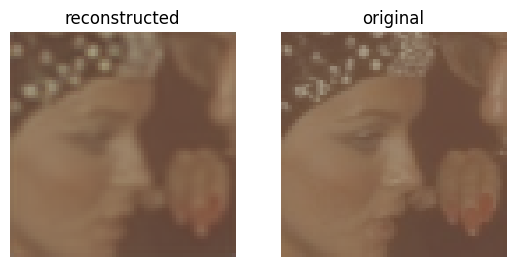

In [9]:

SS = autoencoder.predict(X_test)
plt.subplot(1, 2, 1)
plt.imshow(SS[200])
plt.axis('off')
plt.title(f"reconstructed")


plt.subplot(1, 2, 2)
plt.imshow(X_test[200])
plt.axis('off')
plt.title(f"original")
plt.show()
